In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

In [2]:
# File paths
input_file="C:\\Users\\Hp\\OneDrive\\Documents\\project\\SRU_Project\\data\\IN_Table.csv"
output_file="C:\\Users\\Hp\\OneDrive\\Documents\\project\\SRU_Project\\data\\OUT_Table.csv"

# Read input and output data
data_1=pd.read_csv(input_file).to_numpy()
data_2=pd.read_csv(output_file).to_numpy()

data=np.hstack((data_1,data_2))


In [13]:
# Extract input-output matrices
input_count = 5
output_count = 2

input_matrix = data[:, 0:input_count]
output_matrix = data[:, 5:7]

In [14]:
output_matrix.shape[0]

14401

In [21]:
# Split into training and validation sets (70%-30%)

num_samples=output_matrix.shape[0]
indices=np.random.permutation(num_samples)
train_size=int(0.7*num_samples)
train_indices=indices[:train_size]
valid_indices=indices[train_size:]

train_input=input_matrix[train_indices]
valid_input=input_matrix[valid_indices]
train_output=output_matrix[train_indices]
valid_output=output_matrix[valid_indices]

# Combine train data for easier indexing
train_data=np.hstack((train_input,train_output))


In [23]:
k=50

y_predict_lin=np.zeros((len(valid_input),output_count))

# Build Nearest Neighbors model (Euclidean distance)
nn_model=NearestNeighbors(n_neighbors=k,metric='euclidean')
nn_model.fit(train_input)

# JIT Modeling and Prediction
for i,query_point in enumerate(valid_input):
    distances,indices=nn_model.kneighbors([query_point])
    neighbor_input=train_data[indices[0], 0:input_count]
    neighbor_output=train_data[indices[0], 5:7]

    # Remove missing values if any
    neighbor_input = neighbor_input[~np.isnan(neighbor_input).any(axis=1)]
    neighbor_output = neighbor_output[~np.isnan(neighbor_output).any(axis=1)]

    if neighbor_input.size == 0 or neighbor_output.size == 0:
        y_predict_lin[i, :] = np.nan
        continue

    #fit random forest model for both outputs
    model1=RandomForestRegressor(n_estimators=80,random_state=42)
    model1.fit(neighbor_input, neighbor_output[:,0])

    model2=RandomForestRegressor(n_estimators=60,random_state=42)
    model2.fit(neighbor_input,neighbor_output[:,1])

    y_predict_lin[i,0]=model1.predict([query_point])[0]
    y_predict_lin[i,1]=model2.predict([query_point])[0]
    

In [24]:
#compute mean squared error
mse1 = mean_squared_error(valid_output[:,0],y_predict_lin[:,0])
mse2 = mean_squared_error(valid_output[:,1],y_predict_lin[:,1])
print("mean square error for output 1 : ",mse1)
print("mean square error for output 2 : ",mse2)

mean square error for output 1 :  0.2148167831291489
mean square error for output 2 :  0.36411027278827324


In [25]:
# Compute R-squared
R_squared = []
for j in range(output_count):
    R_squared.append(r2_score(valid_output[:, j], y_predict_lin[:, j]))
print("The R-squared for trained model is:", R_squared)

The R-squared for trained model is: [0.7901032406867529, 0.6411432706303966]


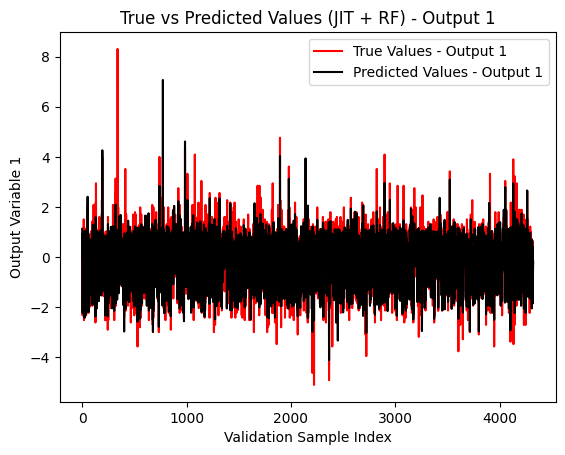

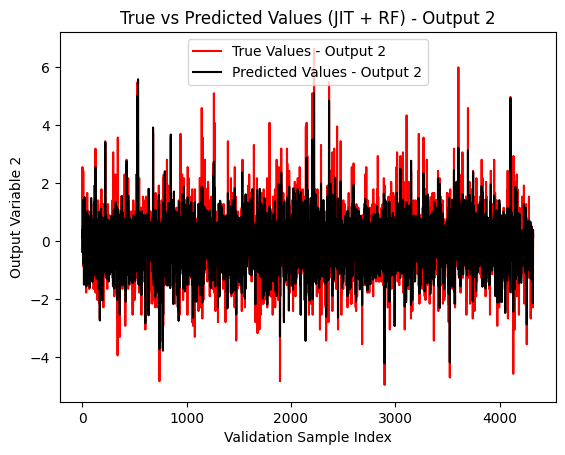

In [26]:
# Plot: True vs Predicted Output 1
plt.figure()
plt.plot(range(len(valid_output)), valid_output[:, 0], 'r', label='True Values - Output 1')
plt.plot(range(len(valid_output)), y_predict_lin[:, 0], 'k', label='Predicted Values - Output 1')
plt.xlabel('Validation Sample Index')
plt.ylabel('Output Variable 1')
plt.title('True vs Predicted Values (JIT + RF) - Output 1')
plt.legend()
plt.show()

# Plot: True vs Predicted Output 2
plt.figure()
plt.plot(range(len(valid_output)), valid_output[:, 1], 'r', label='True Values - Output 2')
plt.plot(range(len(valid_output)), y_predict_lin[:, 1], 'k', label='Predicted Values - Output 2')
plt.xlabel('Validation Sample Index')
plt.ylabel('Output Variable 2')
plt.title('True vs Predicted Values (JIT + RF) - Output 2')
plt.legend()
plt.show()